In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix

In [3]:
df = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.data', names=["user_id", "item_id", "rating", "timestamp"], sep="\t")
df.drop(columns=['rating', 'timestamp'], inplace=True)
df.head()

,user_id,item_id
0,196,242
1,186,302
2,22,377
3,244,51
4,166,346


## 前処理

### itemの購入回数

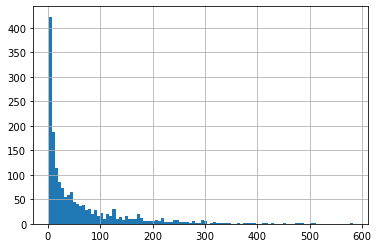

In [4]:
# itemの購入回数のヒストグラム
df_count_item = df.groupby('item_id').count().reset_index().rename(columns={'user_id': 'item_count'})
df_count_item['item_count'].hist(bins=100)
plt.show()

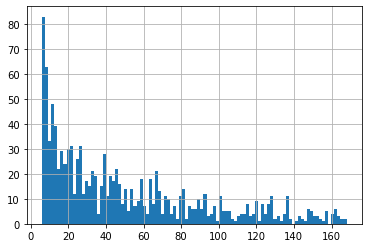

In [5]:
q1 = df_count_item.item_count.quantile(0.2)
q3 = df_count_item.item_count.quantile(0.9)
df_count_item = df_count_item.query('@q1 < item_count < @q3')
df_count_item['item_count'].hist(bins=100)
plt.show()

### userの購入回数

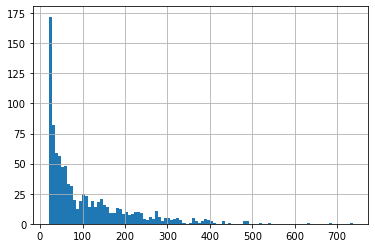

In [6]:
df_count_user = df.groupby('user_id').count().reset_index().rename(columns={'item_id': 'item_count'})
df_count_user['item_count'].hist(bins=100)
plt.show()

In [7]:
df_count_item.item_count.describe()

count    1128.000000
mean       49.638298
std        41.678177
min         6.000000
25%        15.000000
50%        37.000000
75%        72.000000
max       168.000000
Name: item_count, dtype: float64

userの最小購入数が6であるため、今回はuserの絞り込みはしない

### 絞り込み

In [8]:
df = df[df.item_id.isin(df_count_item.item_id)].reset_index(drop=True)

## 行列作成

In [9]:
df['flag'] = 1
df_pivot = df.pivot(index='item_id', columns='user_id', values='flag').fillna(0)
df_np = df_pivot.values
df_sparse = csr_matrix(df_pivot.values)

In [10]:
df_pivot

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
item_id,,,,,,,,,,,,,,,,,,,,,
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_np

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
# item0とitem1との類似性
df_np[0].T @ df_np[1]

34.0

In [13]:
df_np @ df_np.T

array([[131.,  34.,  37., ...,   0.,   6.,   2.],
       [ 34.,  90.,  21., ...,   1.,   3.,   2.],
       [ 37.,  21.,  86., ...,   0.,   1.,   1.],
       ...,
       [  0.,   1.,   0., ...,   6.,   1.,   1.],
       [  6.,   3.,   1., ...,   1.,  10.,   1.],
       [  2.,   2.,   1., ...,   1.,   1.,   9.]])

In [14]:
# sparseの場合、*はアダマール積ではなく、内積になる
print(df_sparse * df_sparse.T)

  (0, 898)	2.0
  (0, 929)	1.0
  (0, 1044)	2.0
  (0, 1115)	2.0
  (0, 1072)	1.0
  (0, 1069)	1.0
  (0, 1065)	1.0
  (0, 1064)	1.0
  (0, 1062)	1.0
  (0, 1061)	1.0
  (0, 1029)	1.0
  (0, 1010)	1.0
  (0, 994)	1.0
  (0, 991)	1.0
  (0, 938)	1.0
  (0, 865)	1.0
  (0, 864)	3.0
  (0, 723)	1.0
  (0, 225)	1.0
  (0, 179)	1.0
  (0, 1127)	2.0
  (0, 1035)	1.0
  (0, 1039)	1.0
  (0, 808)	2.0
  (0, 1126)	6.0
  :	:
  (1127, 170)	2.0
  (1127, 151)	5.0
  (1127, 145)	2.0
  (1127, 137)	2.0
  (1127, 96)	3.0
  (1127, 83)	1.0
  (1127, 82)	3.0
  (1127, 1127)	9.0
  (1127, 869)	2.0
  (1127, 777)	2.0
  (1127, 712)	1.0
  (1127, 686)	2.0
  (1127, 671)	3.0
  (1127, 647)	1.0
  (1127, 506)	4.0
  (1127, 501)	3.0
  (1127, 428)	1.0
  (1127, 376)	2.0
  (1127, 188)	4.0
  (1127, 183)	3.0
  (1127, 158)	5.0
  (1127, 156)	3.0
  (1127, 154)	7.0
  (1127, 152)	5.0
  (1127, 148)	7.0


## NMFなし

### topk-NN(k=1)

In [15]:
k = 1
similarity = df_np @ df_np.T
index = np.argsort(-similarity)[:, 1:k+1]

In [16]:
adj_list = np.arange(len(index))
adj_list = np.concatenate([np.stack([adj_list, index[:, i]]) for i in range(k)], axis=1).T

In [17]:
ind2itemnum = df_pivot.index.values
ind2itemnum

array([   2,    3,    5, ..., 1598, 1615, 1620])

In [18]:
G = nx.Graph()

edges = list(map(lambda x: [ind2itemnum[x[0]], ind2itemnum[x[1]]], adj_list))
G.add_edges_from(edges)

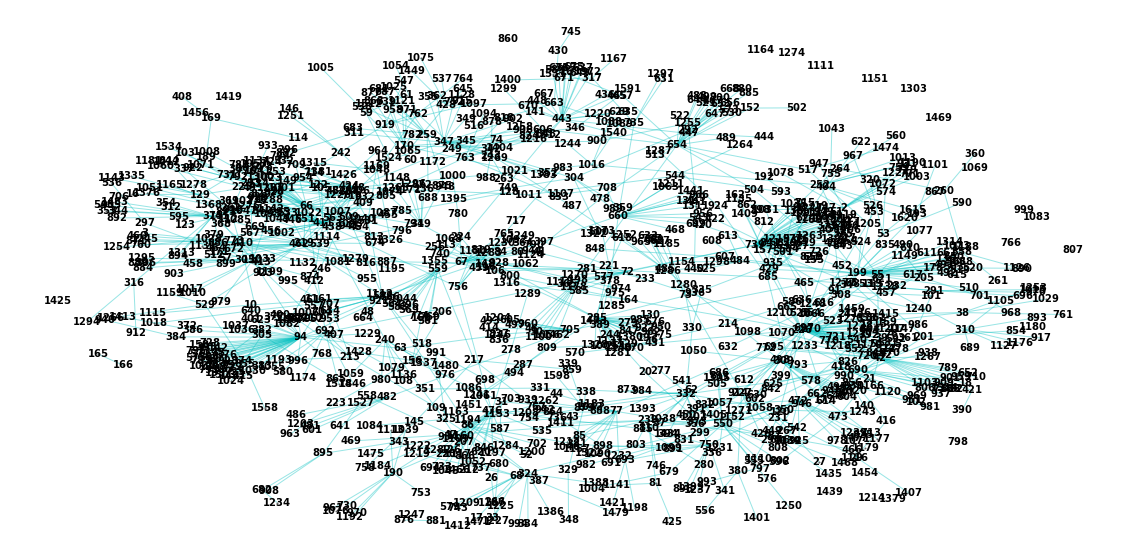

In [19]:
plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.6, node_size=1, edgecolors="k")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="c", width=1)
plt.show()

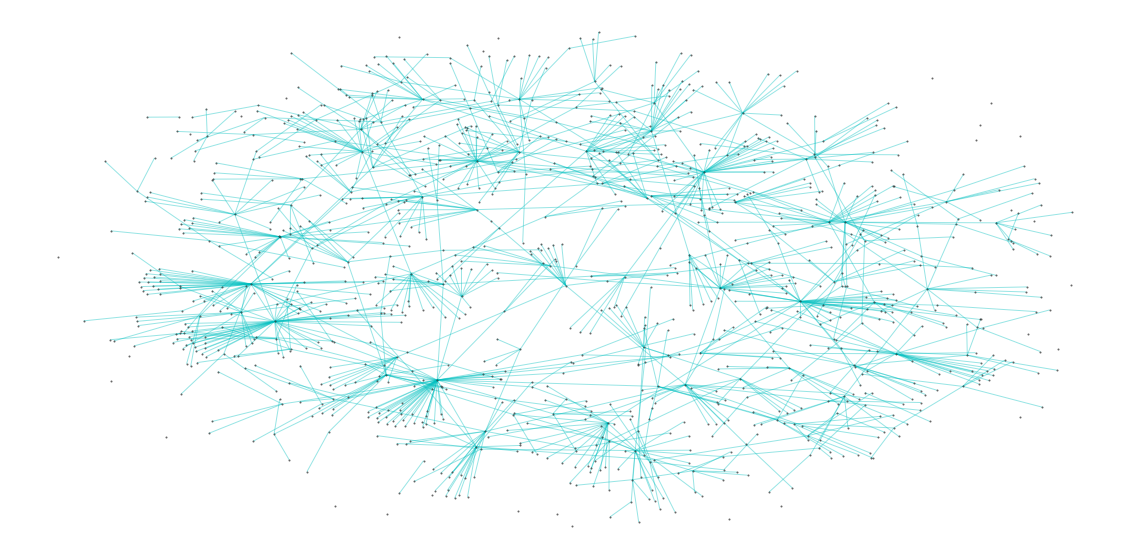

In [20]:
plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.6, node_size=1, edgecolors="k")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="c", width=1)
plt.show()

#### アイテムを指定して、周辺情報を可視化

In [21]:
edges = list(map(lambda x: [ind2itemnum[x[0]], ind2itemnum[x[1]]], adj_list))
item_num = 2
edges = list(filter(lambda x: x[0] == item_num or x[1] == item_num, edges))

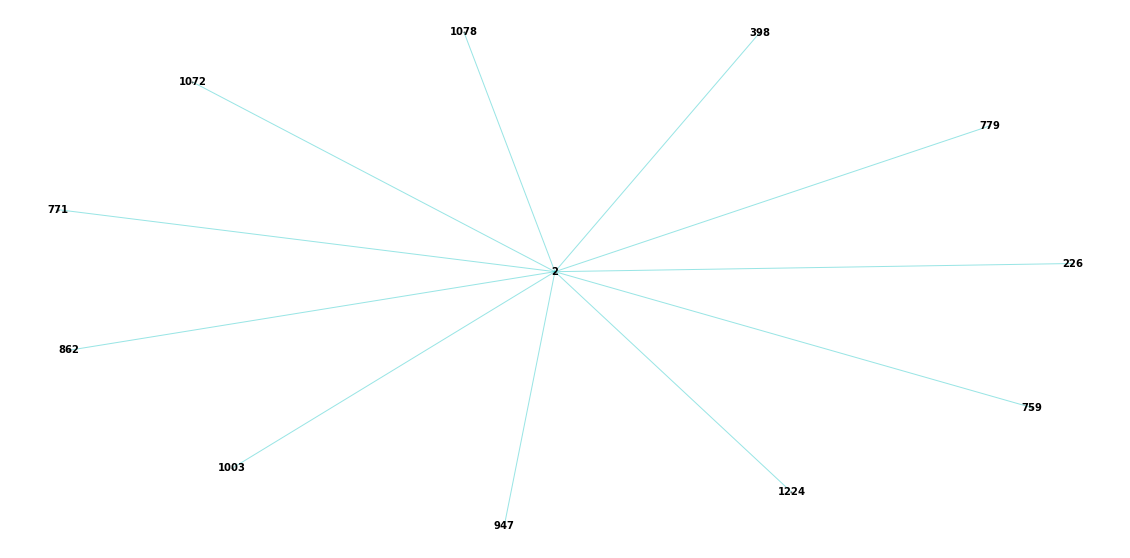

In [22]:
G = nx.Graph()
G.add_edges_from(edges)

plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.6, node_size=1, edgecolors="k")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="c", width=1)
plt.show()

#### 特定のアイテムへの枝の色を変える

In [23]:
G = nx.Graph()
strong_item_num = 0
for u, v in adj_list:
    if u == strong_item_num or v == strong_item_num:
        G.add_edge(ind2itemnum[u], ind2itemnum[v], color='r')
    else:
        G.add_edge(ind2itemnum[u], ind2itemnum[v], color='c')

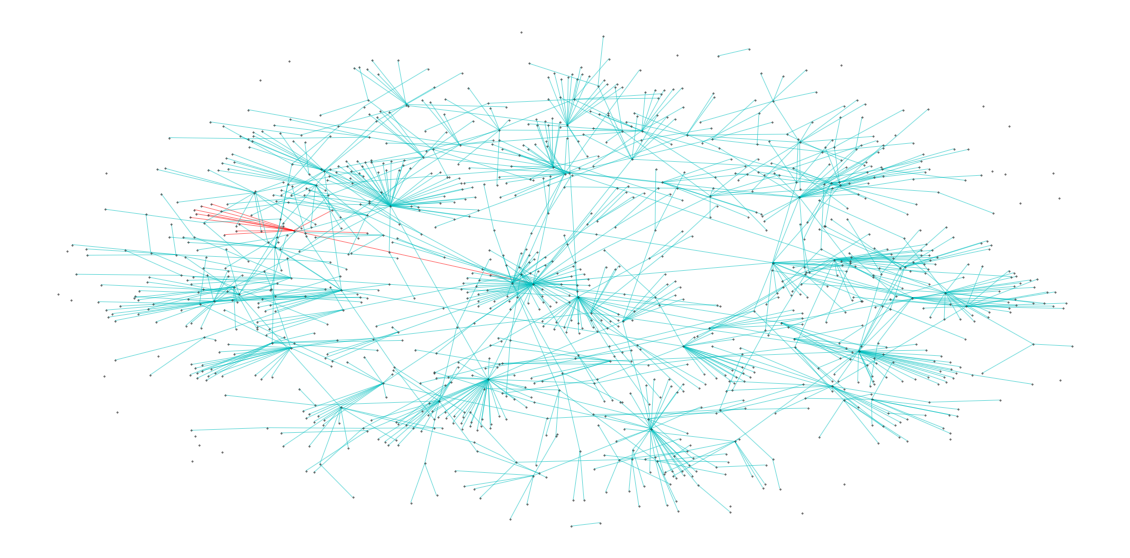

In [24]:
plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.6, node_size=1, edgecolors="k")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color=nx.get_edge_attributes(G, 'color').values(), width=1)
plt.show()

In [25]:
nx.get_edge_attributes(G, 'color')

{(2, 226): 'r',
 (2, 398): 'r',
 (2, 759): 'r',
 (2, 771): 'r',
 (2, 779): 'r',
 (2, 862): 'r',
 (2, 947): 'r',
 (2, 1003): 'r',
 (2, 1072): 'r',
 (2, 1078): 'r',
 (2, 1224): 'r',
 (226, 5): 'c',
 (226, 38): 'c',
 (226, 39): 'c',
 (226, 53): 'c',
 (226, 54): 'c',
 (226, 55): 'c',
 (226, 62): 'c',
 (226, 76): 'c',
 (226, 77): 'c',
 (226, 157): 'c',
 (226, 159): 'c',
 (226, 164): 'c',
 (226, 177): 'c',
 (226, 550): 'c',
 (226, 227): 'c',
 (226, 231): 'c',
 (226, 232): 'c',
 (226, 233): 'c',
 (226, 239): 'c',
 (226, 241): 'c',
 (226, 392): 'c',
 (226, 399): 'c',
 (226, 431): 'c',
 (226, 452): 'c',
 (226, 470): 'c',
 (226, 540): 'c',
 (226, 552): 'c',
 (226, 554): 'c',
 (226, 562): 'c',
 (226, 572): 'c',
 (226, 581): 'c',
 (226, 586): 'c',
 (226, 592): 'c',
 (226, 616): 'c',
 (226, 636): 'c',
 (226, 642): 'c',
 (226, 658): 'c',
 (226, 665): 'c',
 (226, 720): 'c',
 (226, 739): 'c',
 (226, 770): 'c',
 (226, 849): 'c',
 (226, 1207): 'c',
 (226, 1210): 'c',
 (226, 1213): 'c',
 (226, 1217): 'c'

### topk-NN(k=3)

In [272]:
k = 3
similarity = df_np @ df_np.T
index = np.argsort(-similarity)[:, 1:k+1]

In [273]:
adj_list = np.arange(len(index))
adj_list = np.concatenate([np.stack([adj_list, index[:, i]]) for i in range(k)], axis=1).T

In [274]:
ind2itemnum = df_pivot.index.values
ind2itemnum

array([   2,    3,    5, ..., 1598, 1615, 1620])

In [275]:
G = nx.Graph()

edges = list(map(lambda x: [ind2itemnum[x[0]], ind2itemnum[x[1]]], adj_list))
G.add_edges_from(edges)

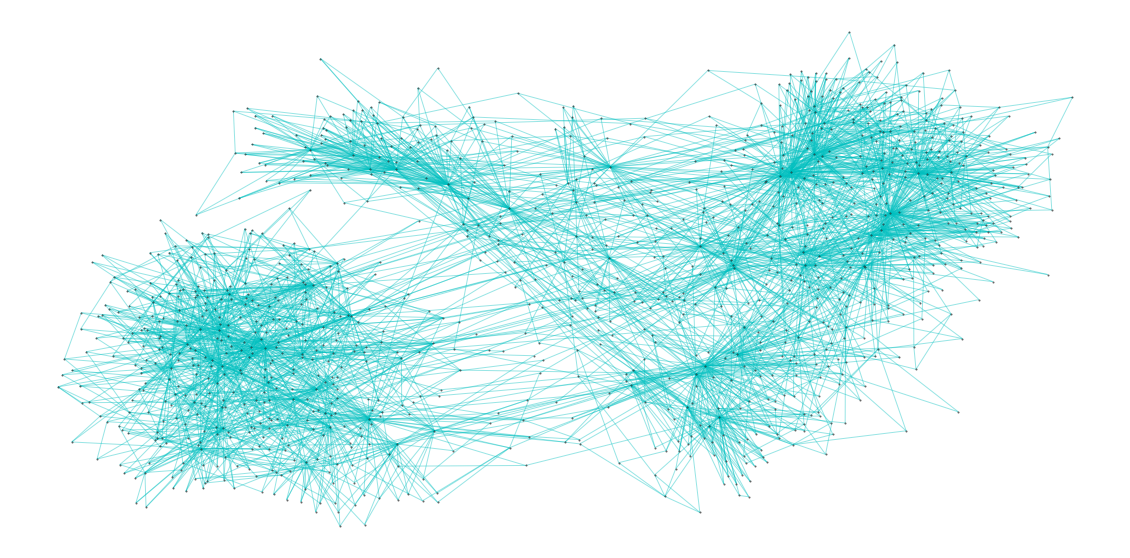

In [277]:
plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.6, node_size=1, edgecolors="k")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="c", width=1)
plt.show()

### $\epsilon$-NN($\epsilon=5$)

In [290]:
eps = 5
similarity = df_np @ df_np.T
adj_list = np.stack(np.where(similarity > eps), axis=1)
adj_list = adj_list[np.where(adj_list[:, 0] != adj_list[:, 1])[0]]

In [291]:
ind2itemnum = df_pivot.index.values

In [292]:
G = nx.Graph()

edges = list(map(lambda x: [ind2itemnum[x[0]], ind2itemnum[x[1]]], adj_list))
G.add_edges_from(edges)

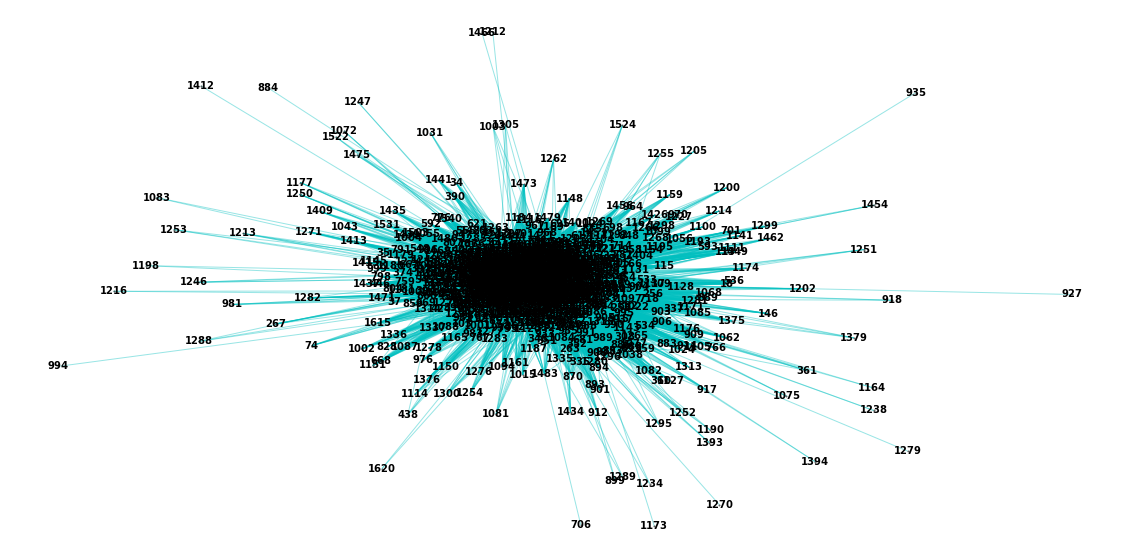

In [293]:
plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.6, node_size=1, edgecolors="k")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="c", width=1)
plt.show()

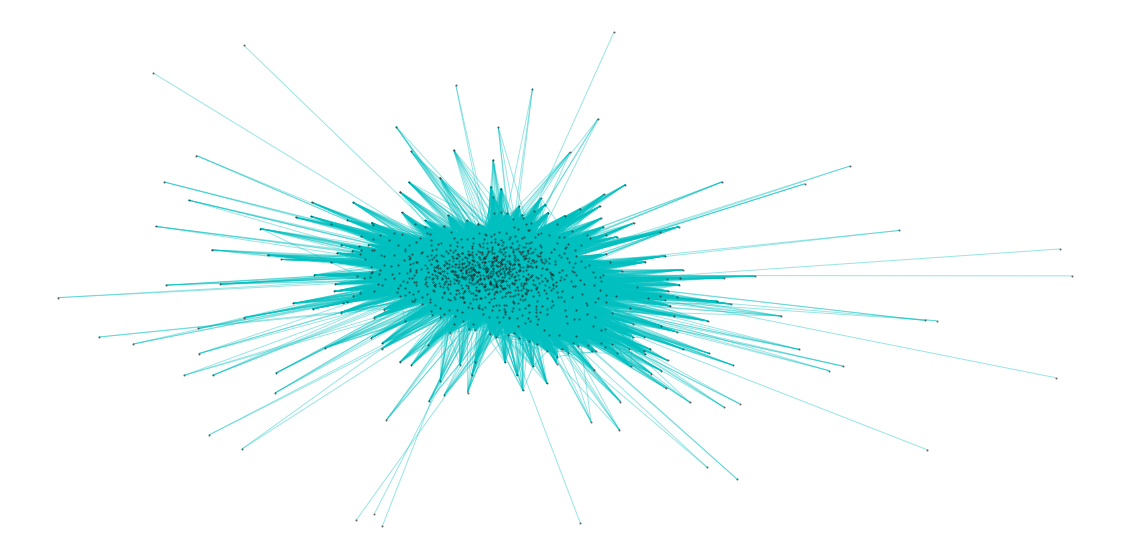

In [294]:
plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.6, node_size=1, edgecolors="k")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="c", width=1)
plt.show()

有用な知見が導き出すことが困難である

## NMF

NMFを用いて次元を圧縮し，潜在クラスへの帰属度ベクトルを用いて，各 Web サイト間の類似度を定義し，ε-NNグラフを生成してみる

In [353]:
df_np.shape

(1128, 943)

In [354]:
K = 8
nmf = NMF(n_components=K, max_iter=1000)
nmf.fit(df_np)

NMF(max_iter=1000, n_components=8)

In [355]:
N = nmf.fit_transform(df_np)
N

array([[0.82643557, 0.05048615, 0.        , ..., 0.0680177 , 0.40475448,
        0.        ],
       [0.31490696, 0.20706334, 0.44513587, ..., 0.        , 0.06014426,
        0.        ],
       [0.16269822, 0.        , 0.11220038, ..., 0.34234074, 0.        ,
        0.79201556],
       ...,
       [0.        , 0.        , 0.03259064, ..., 0.        , 0.        ,
        0.        ],
       [0.03646072, 0.        , 0.01368007, ..., 0.        , 0.06955004,
        0.        ],
       [0.00523986, 0.        , 0.04195306, ..., 0.        , 0.01088074,
        0.        ]])

In [356]:
norm = (N * N).sum(axis=1, keepdims=True) ** .5
similarity = (N @ N.T) / (norm @ norm.T)
similarity

array([[1.        , 0.5427018 , 0.19219758, ..., 0.01552039, 0.76501797,
        0.14989859],
       [0.5427018 , 1.        , 0.19494099, ..., 0.34812595, 0.44585281,
        0.51793151],
       [0.19219758, 0.19494099, 1.        , ..., 0.05812488, 0.10137187,
        0.09091887],
       ...,
       [0.01552039, 0.34812595, 0.05812488, ..., 1.        , 0.32503209,
        0.96719945],
       [0.76501797, 0.44585281, 0.10137187, ..., 0.32503209, 1.        ,
        0.48243065],
       [0.14989859, 0.51793151, 0.09091887, ..., 0.96719945, 0.48243065,
        1.        ]])

In [357]:
eps = 0.99
adj_list = np.stack(np.where(similarity > eps), axis=1)
adj_list = adj_list[np.where(adj_list[:, 0] != adj_list[:, 1])[0]]

In [358]:
ind2itemnum = df_pivot.index.values

In [385]:
G = nx.Graph()

edges = list(map(lambda x: [ind2itemnum[x[0]], ind2itemnum[x[1]]], adj_list))
G.add_edges_from(edges)

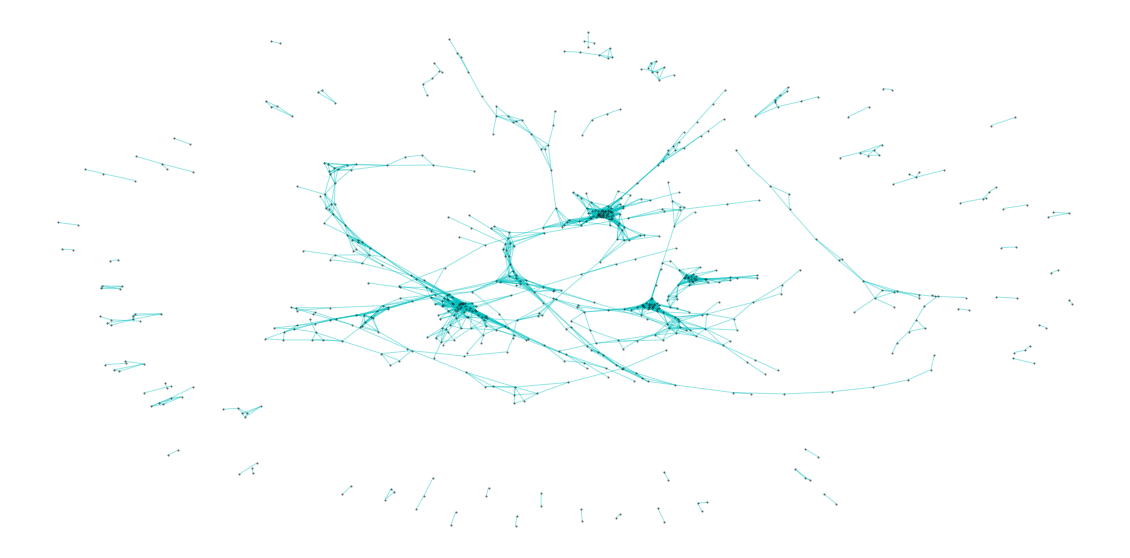

In [386]:
plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G, k=0.05)
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.6, node_size=1, edgecolors="k")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="c", width=1)
plt.show()

### 連結成分が大きいまとまりだけ残す

In [387]:
# 連結成分の個数
nx.number_connected_components(G)

69

In [388]:
G_connect_sets_filter = map(lambda x: list(x), 
                            filter(lambda x: len(x) > 10, 
                                   sorted(nx.connected_components(G), 
                                          key=len, reverse=True)))
sub_nodes = sum(G_connect_sets_filter, [])

In [389]:
sub_edges = list(filter(lambda x: x[0] in sub_nodes and x[1] in sub_nodes, edges))

In [390]:
G_sub = nx.Graph()
G_sub.add_edges_from(sub_edges)

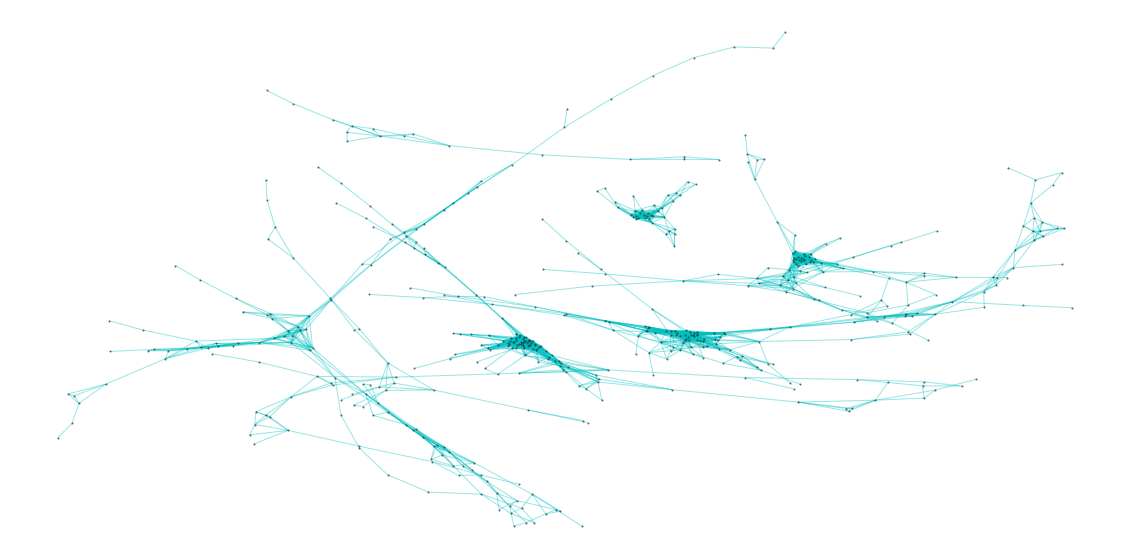

In [391]:
plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G_sub, k=0.05)
nx.draw_networkx_nodes(G_sub, pos, node_color="w", alpha=0.6, node_size=1, edgecolors="k")
nx.draw_networkx_edges(G_sub, pos, alpha=0.4, edge_color="c", width=1)
plt.show()

### 連結成分ごと可視化

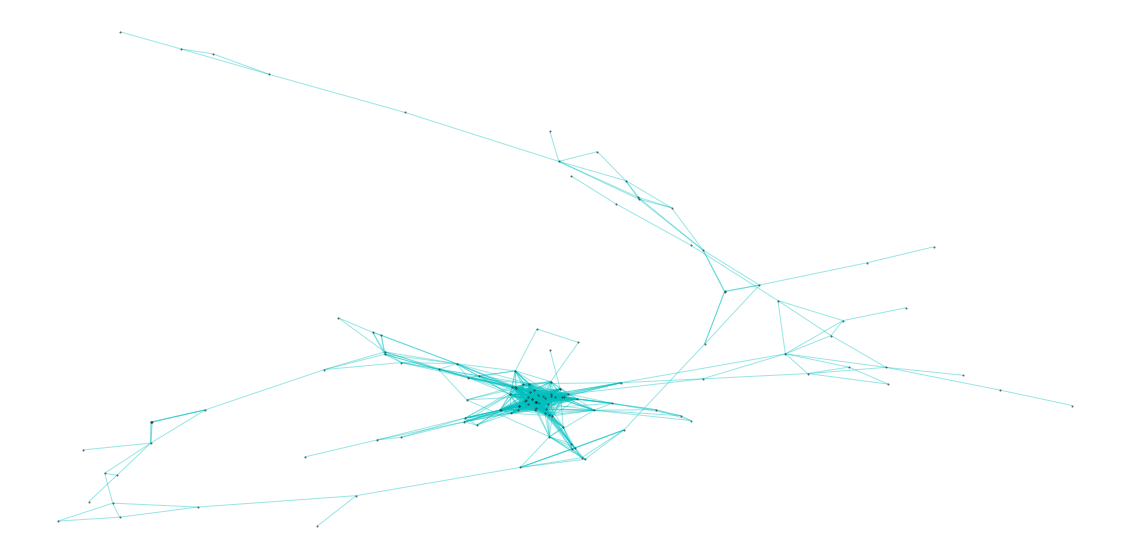

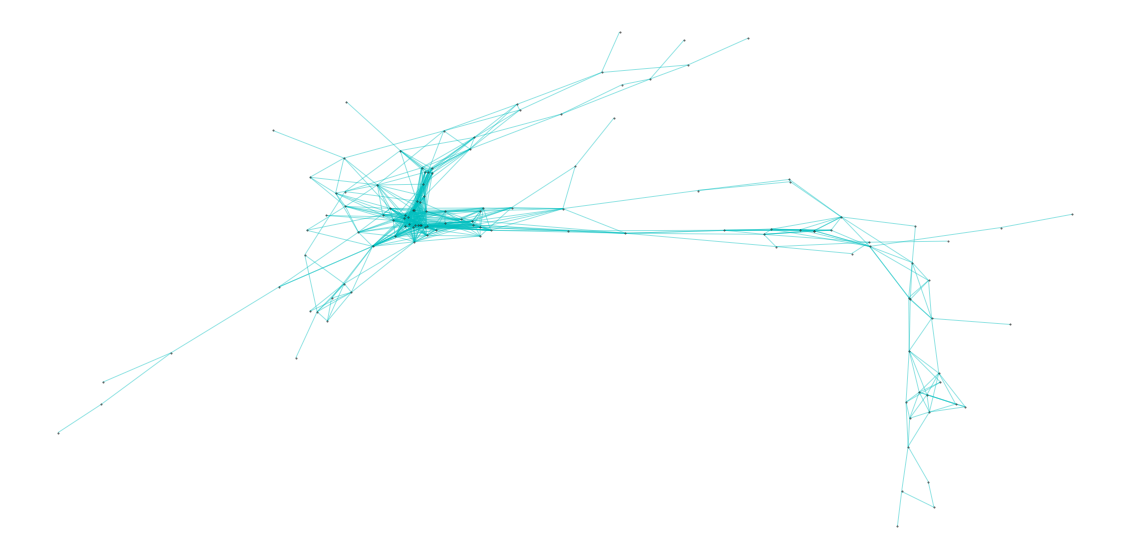

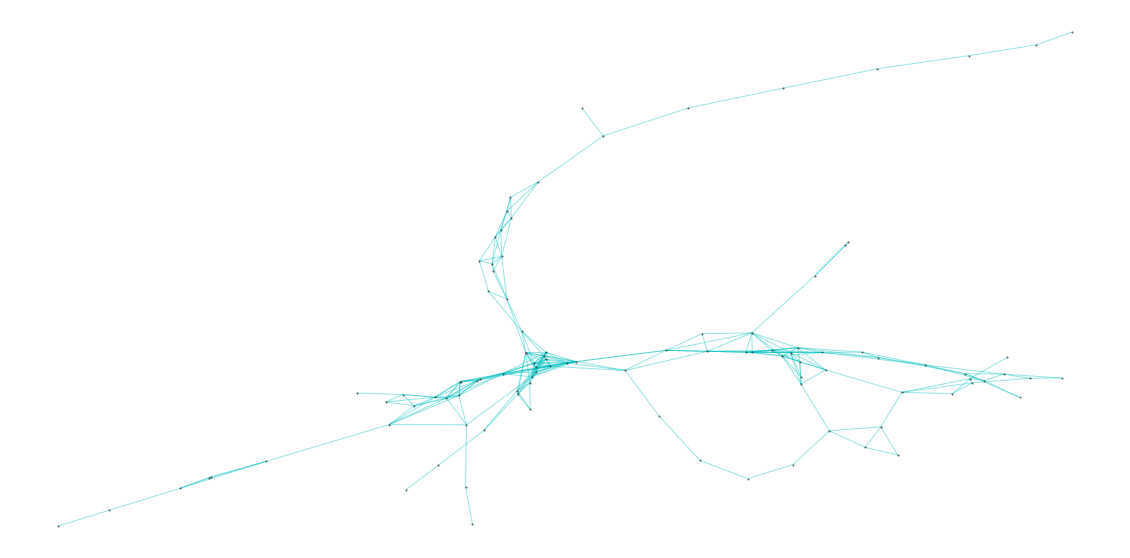

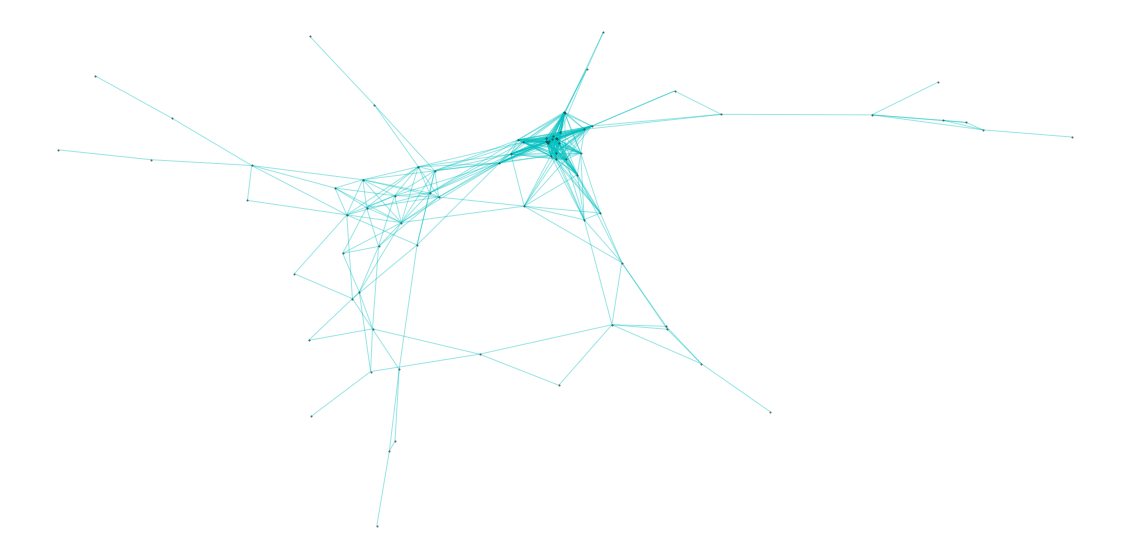

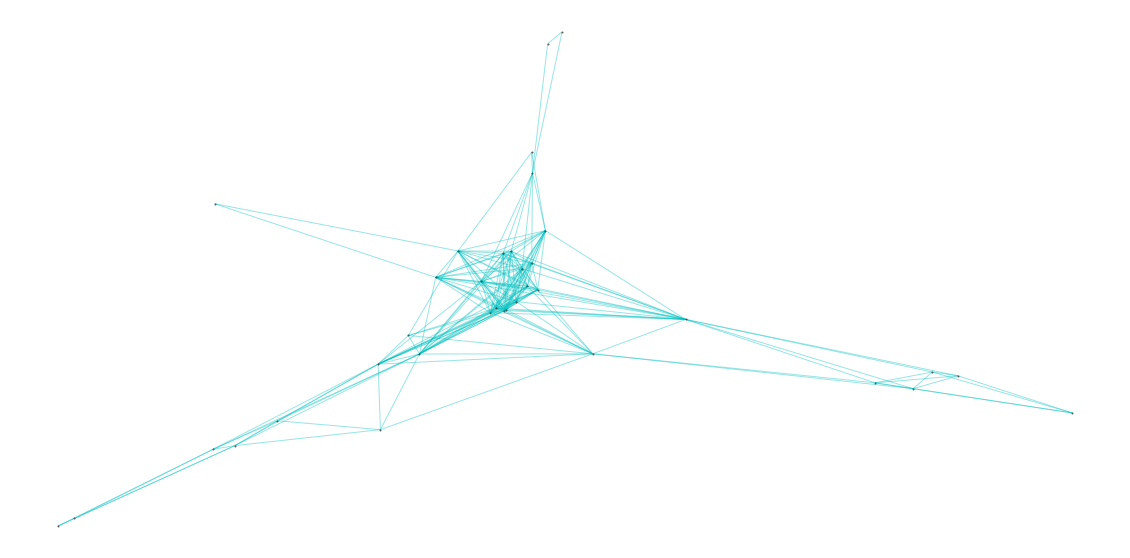

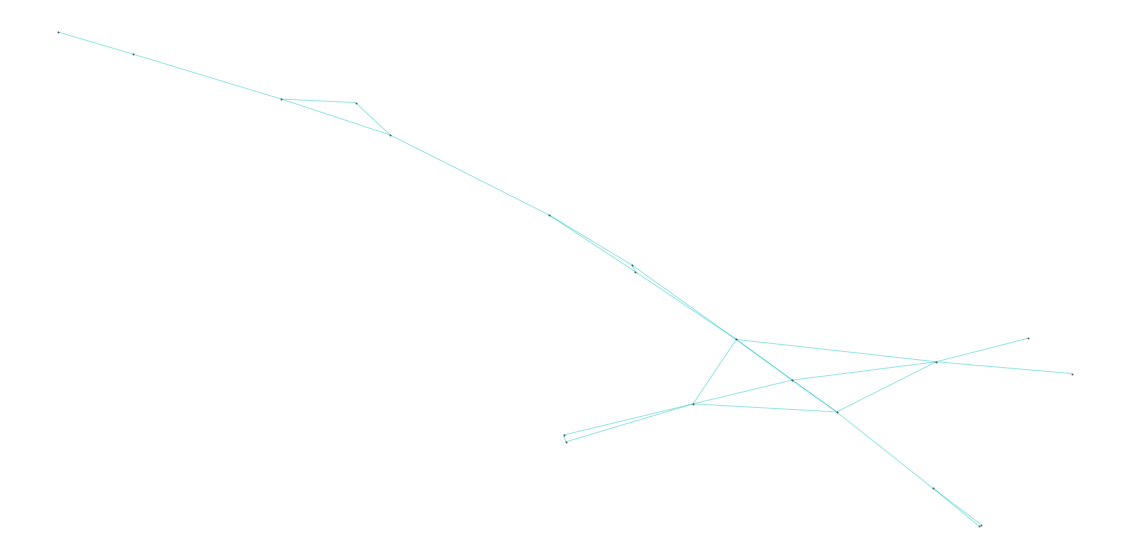

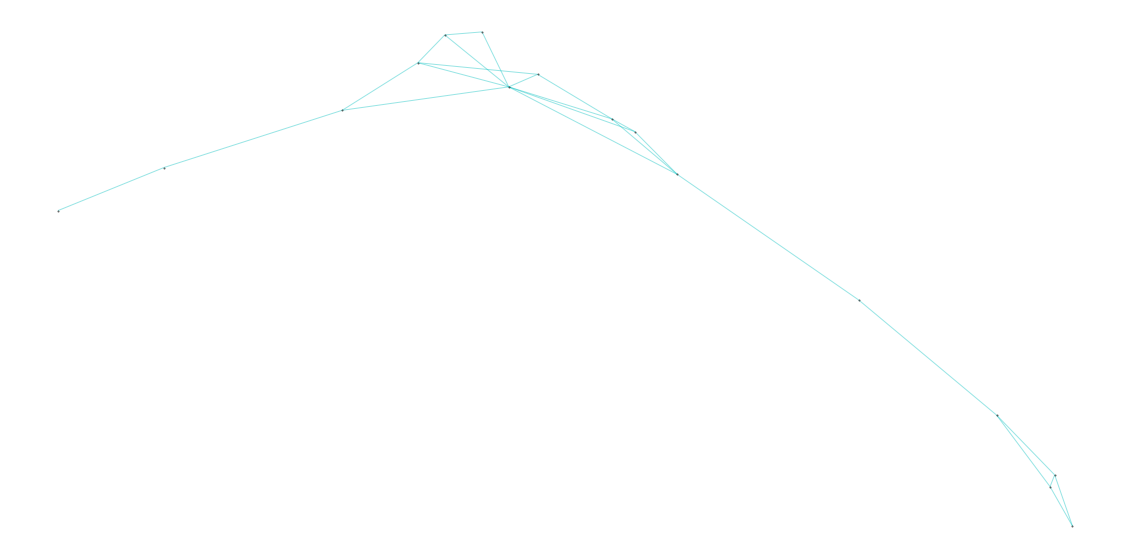

In [395]:
G_connect_sets_filter = map(lambda x: list(x), 
                            filter(lambda x: len(x) > 10, 
                                   sorted(nx.connected_components(G), 
                                          key=len, reverse=True)))
for sub_nodes in G_connect_sets_filter:
    sub_edges = list(filter(lambda x: x[0] in sub_nodes and x[1] in sub_nodes,
                            edges))
    G_sub = nx.Graph()
    G_sub.add_edges_from(sub_edges)
    
    plt.figure(figsize=(20, 10))
    plt.axis('off')
    pos = nx.spring_layout(G_sub, k=0.01)
    nx.draw_networkx_nodes(G_sub, pos, node_color="w", alpha=0.6, node_size=1, edgecolors="k")
    nx.draw_networkx_edges(G_sub, pos, alpha=0.4, edge_color="c", width=1)
    plt.show()

## 参考文献

> [ユーザの行動履歴データを活用したネットワーク分析, 後藤正幸](http://www.orsj.or.jp/archive2/or64-11/or64_11_671.pdf)